## Limpieza de los datos

### Carga de librerías y del conjunto de datos

Importamos las librerías necesarias:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import math

Cargamos los datos originales:

Nos ayudamos de un esquema para ajustar algunos tipos a su contenido

In [2]:
schema = {
    "zipCode": "category",
    "buildingType": "category",
    "buildingSubtype": "category",
    "clientTypeId": "category",
    "periodicityId": "category",
    "conservationState": "category",
    'bathrooms': 'Int8',
    'balcony': 'Int8',
    'air_conditioner': 'Int8',
    'heater': 'Int8',
    'heating': 'Int8',
    'swimming_pool': 'Int8',
    'parking': 'Int8',
    'floor': 'Int8',
    'terrace': 'Int8',
    'elevator': 'Int8',
    'rooms': 'Int8'
}

In [3]:
dataset = pd.read_csv("../data/madrid-rent-prices_raw.csv", dtype=schema)
dataset.head(3)

,_id,zipCode,buildingType,buildingSubtype,clientId,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,...,isPackPremiumPriority,isNewConstruction,hasOpenHouse,isOpportunity,minPrice,otherFeaturesCount,price,periodicityId,history,lastAccess
0,1,28023,Flat,GroundFloorWithGarden,id-1,3,2022-02-24,2,<NA>,<NA>,...,True,False,False,False,0,15,1325.0,3,"[{'date': '2022-04-04', 'price': 1325}]",2022-04-11 07:48:19.078000
1,2,28023,Flat,Flat,id-1,3,2022-02-23,2,<NA>,<NA>,...,True,False,False,False,0,15,1120.0,3,"[{'date': '2022-04-04', 'price': 1120}]",2022-04-11 07:48:19.139000
2,3,28052,Flat,GroundFloorWithGarden,id-2,3,2022-03-10,2,<NA>,<NA>,...,True,False,False,False,0,18,1095.0,3,"[{'date': '2022-04-04', 'price': 1095}]",2022-04-11 07:49:27.115000


Se ajustan las etiquetas de algunas variables categóricas para que que sean más compresibles sus valores

In [4]:
import numpy as np

# Asignación de etiquetas descriptivas a las variables categóricas
dataset['clientTypeId'] = dataset.clientTypeId.cat.rename_categories({"1": "Part.", "3": "Inmob."})
dataset['conservationState'] = dataset.conservationState.cat.rename_categories({
        "0": "Desconocido",
        "1": "Casi nuevo",
        "2": "Muy bueno",
        "3": "Bueno",
        "4": "A reformar",
        "8": "Reformado"
    })

dataset['periodicityId'] = dataset.periodicityId.cat.rename_categories({'0': "Desconocido", '3': "Mensual"})

# Conversión de algunas columnas a Datetime
dataset['dateOriginal'] = pd.to_datetime(dataset.dateOriginal)
dataset['lastAccess'] = pd.to_datetime(dataset.lastAccess)



#### Conversión de _history_ a variable numérica

La variables history contiene todas las modificaciones en el precio ofertado para un inmueble que se han capturado en los procesos de extracción de información. Para que el contenido de esta variable se pueda explotar en el modelo se va a convertir a una variable numérica que va a contener la diferencia entre el precio inicial y el precio final ofertado para ese inmueble.

In [5]:
import json


def bajada(h):
    h = h.replace("'", '"').replace("None", "null")
    try:
        h = json.loads(h)
    except:
        print(h)
        return 0
    if h[-1]['price'] and h[0]['price']:
        return h[-1]['price'] - h[0]['price']
    else:
        return 0


my_h = "[{'date': '2022-04-04', 'price': 1320}, {'date': '2022-04-04', 'price': 1300}]"
assert bajada(my_h) == -20
my_h = '[{"date": "2022-04-04", "price": 2500}, {"date": "2022-04-04", "price": None}, {"date": "2022-04-06", "price": 2400}]'
assert bajada(my_h) == -100

In [6]:
dataset['price_var'] = dataset['history'].apply(bajada)
dataset['price_var'].value_counts()[:5]

 0      6687
-50       53
-100      41
 100      17
-25       16
Name: price_var, dtype: int64

Una vez que tenemos calculada esta columna, eliminamos _history_

In [7]:
dataset.drop('history', axis=1, inplace=True)

### Revisión de valores nulos

Calculamos la cantidad de valores nulos que contiene cada variable

In [8]:
vars_null = dataset.isnull().sum()
vars_null = vars_null[vars_null > 0]
vars_null.sort_values(ascending=False)

heating              6731
swimming_pool        6451
parking              6383
balcony              6197
terrace              5363
conservationState    3072
elevator             2359
floor                2279
air_conditioner      2240
heater               2060
rooms                 265
bathrooms              55
surface                33
price                  25
zipCode                 1
dtype: int64

Se observa que existe un registro con valor nulo en `zipCode`, al ser sólo uno y puesto que es una variable que afecta mucho al precio del alquiler vamos a eliminar este elemento

In [9]:
# Se descartan las filas con zipcode nulo
dataset = dataset[dataset.zipCode.notnull()]

Las variables `surface` y `prices` se completarán mediante un cálculo en función del resto de características. Vamos del resto de variables.

In [10]:
features = ['bathrooms', 'balcony', 'air_conditioner', 
             'heater', 'heating', 'swimming_pool', 'parking', 
             'conservationState', 'floor', 'terrace', 
             'elevator', 'rooms']

for feat in features:
    print(feat + ':', list(dataset[feat].unique()))


bathrooms: [2, 3, 1, 5, 4, <NA>, 6, 7, 8]
balcony: [<NA>, 1]
air_conditioner: [<NA>, 1]
heater: [<NA>, 1]
heating: [<NA>, 1]
swimming_pool: [<NA>, 1]
parking: [<NA>, 1]
conservationState: ['Casi nuevo', nan, 'Bueno', 'Muy bueno', 'A reformar', 'Reformado']
floor: [3, 6, 8, 7, <NA>, 11, 9, 10, 21, 12, 14, 13, 1, 16, 15, 17, 2, 20, 5, 18, 4, 19]
terrace: [1, <NA>]
elevator: [1, <NA>]
rooms: [2, 3, 1, 5, 4, <NA>, 7, 6, 9, 15, 8, 11]


Añadimos la etiqueta "Desconocido" a la variable categórica _conservationState_ y la utilizamos para sustituir a los valores nulos

In [11]:
dataset["conservationState"] = dataset["conservationState"]\
                                        .cat.add_categories("Desconocido")\
                                        .fillna("Desconocido")

Para el resto de variables hacemos una sustitución de nulos por ceros

In [12]:
for feat in features:
    if feat != "conservationState":
        dataset[feat] = dataset[feat].fillna(0).astype("int8")



In [13]:
vars_null = dataset.isnull().sum()
vars_null = vars_null[vars_null > 0]
vars_null.sort_values(ascending=False)


surface    33
price      25
dtype: int64

Por otro lado, tenemos en las variables _surface_ y _price_ algunos valores que no quedaron registrados generando nulos. Para solventar esto aplicaremos una imputación de valores mediante el algoritmo KNN, observando los 5 valores más cercanos y asignando el valor que le corresponda. Todo esto bajo la premisa de que los registros más cercanos tendrán un valor semejante al real por lo que a través de ellos se puede imputar dicho valor.


Para esto usaremos las variables numéricas que tiene el conjunto original debido a que el algoritmo KNN es un algoritmo que trabaja con distancias, por lo que es necesario aplicarlo usando valores numéricos:

In [14]:

# Hacemos una copia del dataset y eliminamos variables que no nos interesan
ndf = dataset.copy()
ndf.drop(['_id', 'clientId'], axis=1, inplace=True)

# Convertimos las categóricas a su código numérico y eliminamos las datetime
for feat in ndf.columns:
    if ndf[feat].dtype == 'category':
        ndf[feat] = ndf[feat].cat.codes
    elif ndf[feat].dtype == 'datetime64[ns]':
        ndf.drop(feat, inplace=True, axis=1)

In [15]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7061 entries, 0 to 7061
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   zipCode                7061 non-null   int8   
 1   buildingType           7061 non-null   int8   
 2   buildingSubtype        7061 non-null   int8   
 3   clientTypeId           7061 non-null   int8   
 4   bathrooms              7061 non-null   int8   
 5   balcony                7061 non-null   int8   
 6   air_conditioner        7061 non-null   int8   
 7   heater                 7061 non-null   int8   
 8   heating                7061 non-null   int8   
 9   swimming_pool          7061 non-null   int8   
 10  parking                7061 non-null   int8   
 11  conservationState      7061 non-null   int8   
 12  floor                  7061 non-null   int8   
 13  terrace                7061 non-null   int8   
 14  elevator               7061 non-null   int8   
 15  room

In [16]:
knn = KNNImputer(n_neighbors=5)
ndf[ndf.columns] = knn.fit_transform(ndf)

Con esto ya tenemos todos nuestros datos nulos imputados:

In [17]:
dataset['price'] = ndf['price']
dataset['surface'] = ndf['surface']
dataset.isnull().sum()

_id                      0
zipCode                  0
buildingType             0
buildingSubtype          0
clientId                 0
clientTypeId             0
dateOriginal             0
bathrooms                0
balcony                  0
air_conditioner          0
heater                   0
heating                  0
swimming_pool            0
parking                  0
conservationState        0
floor                    0
terrace                  0
elevator                 0
rooms                    0
surface                  0
isHighlighted            0
isPackPremiumPriority    0
isNewConstruction        0
hasOpenHouse             0
isOpportunity            0
minPrice                 0
otherFeaturesCount       0
price                    0
periodicityId            0
lastAccess               0
price_var                0
dtype: int64

### Selección de variables
Seleccionamos los datos entre el 4 y 11 de abril para evitar sesgos.

In [18]:
## Eliminamos las variables _id y clientId y seleccionamos el rango de fechas
alquiler = dataset.drop(['_id', 'clientId'], axis=1)
                  #.loc[(dataset.dateOriginal>="2022-04-04") & (dataset.dateOriginal<="2022-04-08")]
alquiler.describe(datetime_is_numeric=True).transpose()

,count,mean,min,25%,50%,75%,max,std
dateOriginal,7061,2022-02-27 21:23:22.577538816,2018-10-22 00:00:00,2022-02-26 00:00:00,2022-03-21 00:00:00,2022-04-01 00:00:00,2022-04-11 00:00:00,NaN
bathrooms,7061.0,1.568191,0.0,1.0,1.0,2.0,8.0,0.854783
balcony,7061.0,0.122504,0.0,0.0,0.0,0.0,1.0,0.32789
air_conditioner,7061.0,0.682906,0.0,0.0,1.0,1.0,1.0,0.465377
heater,7061.0,0.708398,0.0,0.0,1.0,1.0,1.0,0.454532
heating,7061.0,0.046877,0.0,0.0,0.0,0.0,1.0,0.211391
swimming_pool,7061.0,0.086532,0.0,0.0,0.0,0.0,1.0,0.281167
parking,7061.0,0.096162,0.0,0.0,0.0,0.0,1.0,0.294834
floor,7061.0,4.964453,0.0,0.0,6.0,8.0,21.0,4.338151
terrace,7061.0,0.240617,0.0,0.0,0.0,0.0,1.0,0.427489


### Valores extremos

Nos centraremos en el análisis de las variables `price` y `surface` para ver si en ellas hay valores que puedan ser considerados outliers

#### Price

Mostrando el diagrama de cajas vemos como existen dos puntos que superan el valor 100000, considerándolos _outliers_ (ya que se aleja bastante del 3 cuartil) obtenemos el siguiente resultado:

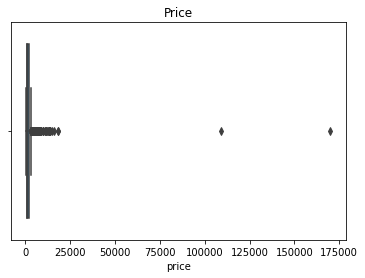

In [19]:
sns.boxplot(x=alquiler.price)
plt.gca().set_title("Price")
plt.show()

Si los eliminamos:

In [20]:
alquiler = alquiler[alquiler.price < 20000]

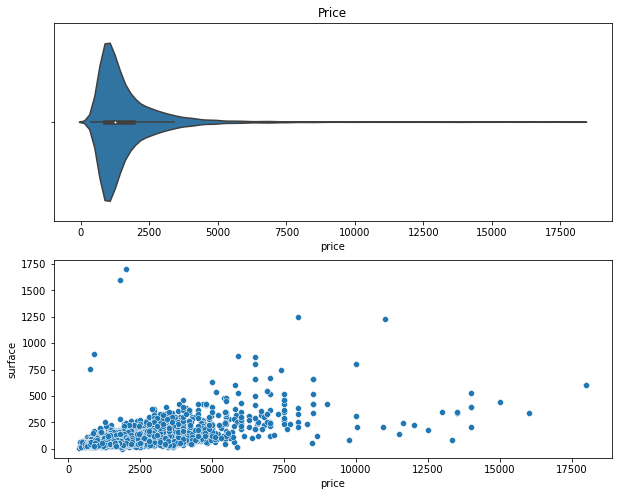

In [21]:
fig, ax = plt.subplots(2,1,figsize=(10,8))

sns.violinplot(x=alquiler.price, ax=ax[0])
ax[0].set_title("Price")

sns.scatterplot(x="price", y="surface", data=alquiler, ax=ax[1])
plt.show()

Aunque siguen existiendo datos que se podrían considerar outliers, el precio es una variable que está muy influenciada por otras características, por ejemplo, la superficie, como se aprecia en el gráfico anterior; o la situación o uso que se le pueda dar al inmueble, por lo que en el caso de esta variable el análisis de outliers monovariantes puede ser problemático y llegar a eliminar alejados mucho de la desviación estándar y que ese alejamiento esté explicado por otra variable.

#### Surface

En el caso de la segunda variable, la variable *surface*, vemos que existen algunos valores que también se alejan por la parte superior del conjunto global:

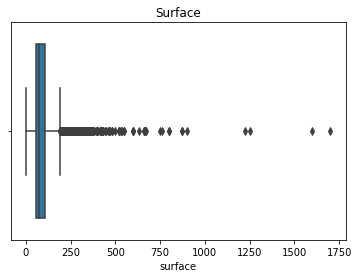

In [22]:
sns.boxplot(x=alquiler.surface)
plt.gca().set_title("Surface")
plt.show()

Pero son valores que entran en los parámetros existentes para ciertas viviendas y es conveniente que el modelo incluya información para ellos.

### Revisión del dominio de algunas columnas

Como primer paso vamos a ver si existen variables que sólo tengan un valor

In [23]:
valores_unicos = [v for v in alquiler if len(alquiler[v].unique()) == 1]
valores_unicos

['buildingType', 'hasOpenHouse', 'minPrice']

Estas variables no aportan información al modelo, por lo que vamos a eliminarlas

In [24]:
alquiler.drop(valores_unicos, axis=1, inplace=True)

#### zipCode
Esta variable también tiene mucha importancia en la determinación de las características asociadas a un alquiler, y por tanto afecta al precio y a la facilidad para alquilarlo, que es el objetivo que hemos planteado para el modelo. Por ello vamos a realizar un estudio de la división de los inmueble por código postal, para ver cómo es la dispersión de los elementos.

En primer lugar analizamos el dominio de valores, ya que al ser inmuebles de la ciudad de Madrid, todos los códigos postales deberían empezar por '280*'

In [25]:
zipCode_280 = alquiler.zipCode.str.startswith("280")

sum(zipCode_280), sum(~zipCode_280)

(7054, 5)

In [26]:
alquiler[~zipCode_280].iloc[:, :8]

,zipCode,buildingSubtype,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,heater
492,28669,SemidetachedHouse,Inmob.,2022-03-18,4,0,1,1
1847,28701,Flat,Inmob.,2022-03-30,1,0,0,1
3563,28224,Flat,Part.,2022-03-07,2,0,1,1
5273,04621,Apartment,Inmob.,2022-04-04,1,0,0,0
5427,33201,Flat,Inmob.,2022-04-05,1,0,0,1


Hay dos inmuebles que tienen un código postal erróneo para el objetivo que se ha planteado en el modelo. Vamos a eliminar estos inmuebles para que no produzcan resultados inesperados.

In [27]:
alquiler = alquiler[zipCode_280]
alquiler.shape

(7054, 26)

Por tener idea de cómo se distribuyen geograficamente los inmuebles vamos a realizar un mapa con la cantidad de inmuebles por código postal

In [28]:
import geopandas as gpd
import contextily as ctx

ERROR 1: PROJ: proj_create_from_database: Open of /home/jose/miniconda3/envs/tdd_pra2/share/proj failed


In [29]:
#Cargamos el fichero geojson de la comunidad de madrid y nos quedamos con los códigos postales de madrid ciudad
madrid = gpd.read_file('../data/MADRID.geojson')
madrid = madrid[madrid.COD_POSTAL.str.startswith("280")]

In [30]:
alquiler_zip_count = alquiler.groupby('zipCode').size().to_frame("count")
alquiler_zip_count.head(4)
        

,count
zipCode,
04621,0
28000,21
28001,271
28002,186


In [31]:
madrid_map_data = madrid.join(alquiler_zip_count, on="COD_POSTAL")
madrid_map_mercator = madrid_map_data.to_crs(epsg=3857)

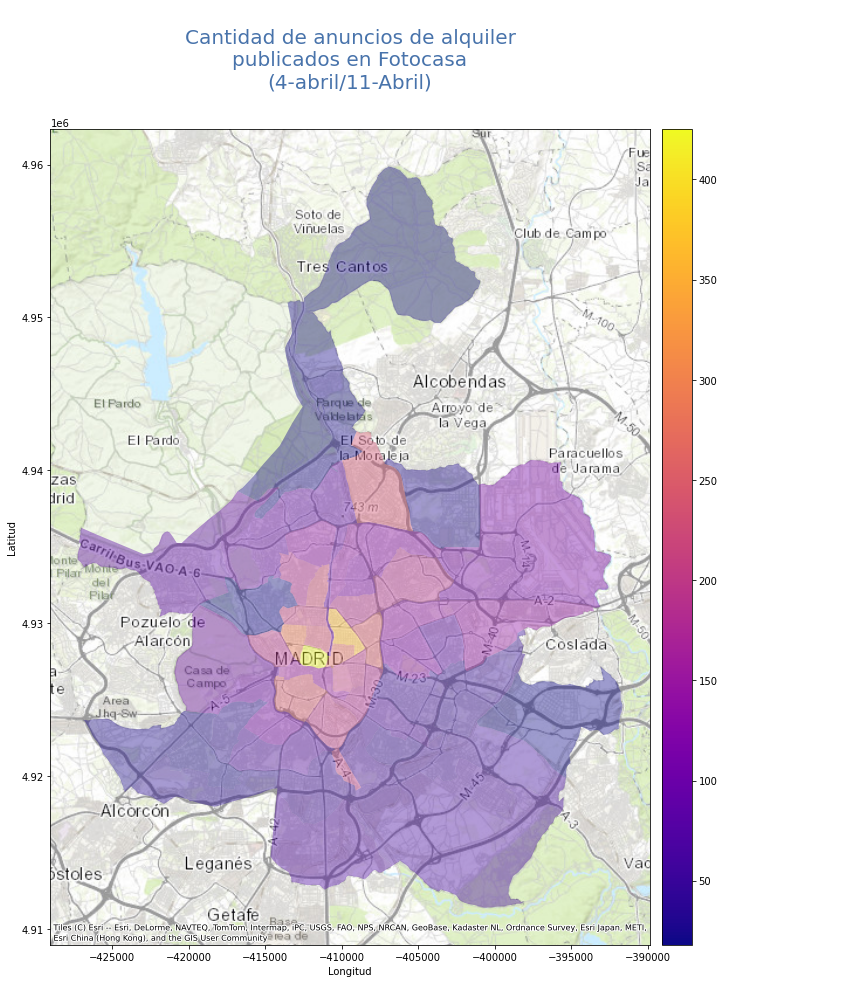

In [32]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
 
# Control del título y los ejes
title="""
Cantidad de anuncios de alquiler
publicados en Fotocasa
(4-abril/11-Abril)
"""
ax.set_title(title, 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%", alpha=0.4)
 
# Generar y cargar el mapa
madrid_map_mercator.plot( column="count",
                          alpha=0.4,
                          cmap='plasma', ax=ax,
                          legend=True, cax=cax, 
                          zorder=5)

#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap, zoom=12)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)


Se puede apreciar que en el centro de la ciudad existe más oferta de alquiler que en las zonas periféricas.

## Análisis visual de los datos

### Diagramas de frecuencia

Haremos un primer estudio 

In [33]:
def count_plot(df, col, ax):
    if not ax:
        ax = plt.gca()
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(col)
    len_labels = [len(l.get_text()) for l in ax.get_xticklabels()]
    if len(len_labels) > 10:
        #eliminar labels del eje x
        ax.set_xticklabels([])
    elif max(len_labels) > 4:
        ax.tick_params(axis="x", rotation=30)
    ax.set_xlabel(None)



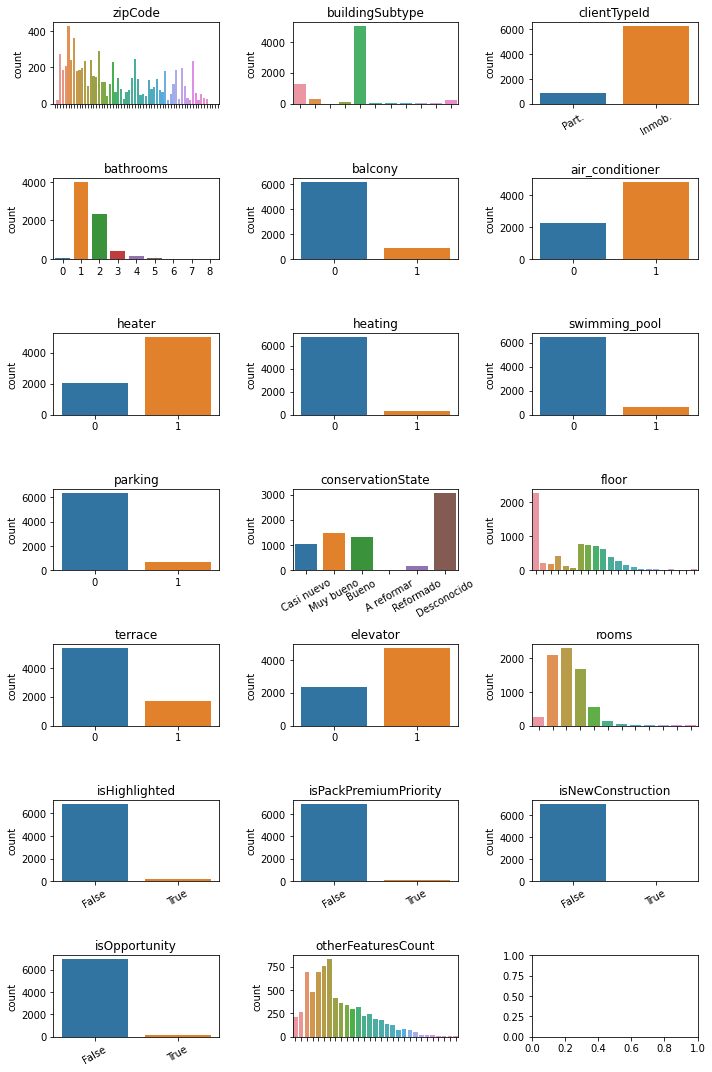

In [34]:

freq_plot = ['zipCode', 'buildingSubtype', 'clientTypeId',
       'bathrooms', 'balcony', 'air_conditioner', 'heater',
       'heating', 'swimming_pool', 'parking', 'conservationState', 'floor',
       'terrace', 'elevator', 'rooms', 'isHighlighted',
       'isPackPremiumPriority', 'isNewConstruction', 
       'isOpportunity', 'otherFeaturesCount']
cols = 3
rows = math.ceil(len(freq_plot) / cols)

fig, axis = plt.subplots(rows, cols, figsize=(10, 15))

# convertir matrix de axis en vector
axis = axis.flatten()

for i, col in enumerate(freq_plot):
    count_plot(alquiler, col, axis[i])


fig.tight_layout()


Vemos que hay varias variables que contienen valores binarios y que en una gran mayoría de las ocasiones predomina uno de ellos, vamos a estudiar estas variables binarias de forma numérica. Para ello vamos a imprimir el procentaje que cada valora para cada una de ellas

In [35]:
for v in freq_plot:
    freq = alquiler[v].value_counts(normalize=True)
    if len(freq) == 2:
        print (f"Variable {v:<22}--> ", end="")
        for i, pct in freq.items():
               print(f"  {str(i):<6}: {pct:.1%}", end= "\t")
        print()


Variable clientTypeId          -->   Inmob.: 88.4%	  Part. : 11.6%	
Variable balcony               -->   0     : 87.7%	  1     : 12.3%	
Variable air_conditioner       -->   1     : 68.3%	  0     : 31.7%	
Variable heater                -->   1     : 70.9%	  0     : 29.1%	
Variable heating               -->   0     : 95.3%	  1     : 4.7%	
Variable swimming_pool         -->   0     : 91.4%	  1     : 8.6%	
Variable parking               -->   0     : 90.4%	  1     : 9.6%	
Variable terrace               -->   0     : 76.0%	  1     : 24.0%	
Variable elevator              -->   1     : 66.6%	  0     : 33.4%	
Variable isHighlighted         -->   False : 97.3%	  True  : 2.7%	
Variable isPackPremiumPriority -->   False : 98.1%	  True  : 1.9%	
Variable isNewConstruction     -->   False : 99.9%	  True  : 0.1%	
Variable isOpportunity         -->   False : 98.3%	  True  : 1.7%	


De esta primera visualización podemos ver que de los elementos de la muestra:
* La inmensa mayoría de los anuncios son incluídos por inmobiliarias 95% (clientTypeId)
* En casi ningún caso se utilizan las opciones que promoción de anuncios (isHighslighted, isPackPremiumPriority, isOpportunity)
* La mayoría de los anuncios ofertan pisos de segunda mano
* La característica añadida más común en los anuncios es la presencia de ascensor 72%

### Análisis de correlación entre variables

A continuación vamos a revisar la correlación entre las variables bathrooms, floor, rooms, suface, otherFeaturesCount y price

In [36]:
alqui_plot = alquiler.select_dtypes(exclude=["category","datetime", "object","timedelta","bool"])
alqui_plot.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7054 entries, 0 to 7061
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bathrooms           7054 non-null   int8   
 1   balcony             7054 non-null   int8   
 2   air_conditioner     7054 non-null   int8   
 3   heater              7054 non-null   int8   
 4   heating             7054 non-null   int8   
 5   swimming_pool       7054 non-null   int8   
 6   parking             7054 non-null   int8   
 7   floor               7054 non-null   int8   
 8   terrace             7054 non-null   int8   
 9   elevator            7054 non-null   int8   
 10  rooms               7054 non-null   int8   
 11  surface             7054 non-null   float64
 12  otherFeaturesCount  7054 non-null   int64  
 13  price               7054 non-null   float64
 14  price_var           7054 non-null   int64  
dtypes: float64(2), int64(2), int8(11)
memory usage: 609.4 K

In [37]:


sns.set(style="white")

mean = np.zeros(3)
cov = np.random.uniform(.2, .4, (3, 3))
cov += cov.T
cov[np.diag_indices(3)] = 1
data = np.random.multivariate_normal(mean, cov, 100)
df = pd.DataFrame(data, columns=["X", "Y", "Z"])

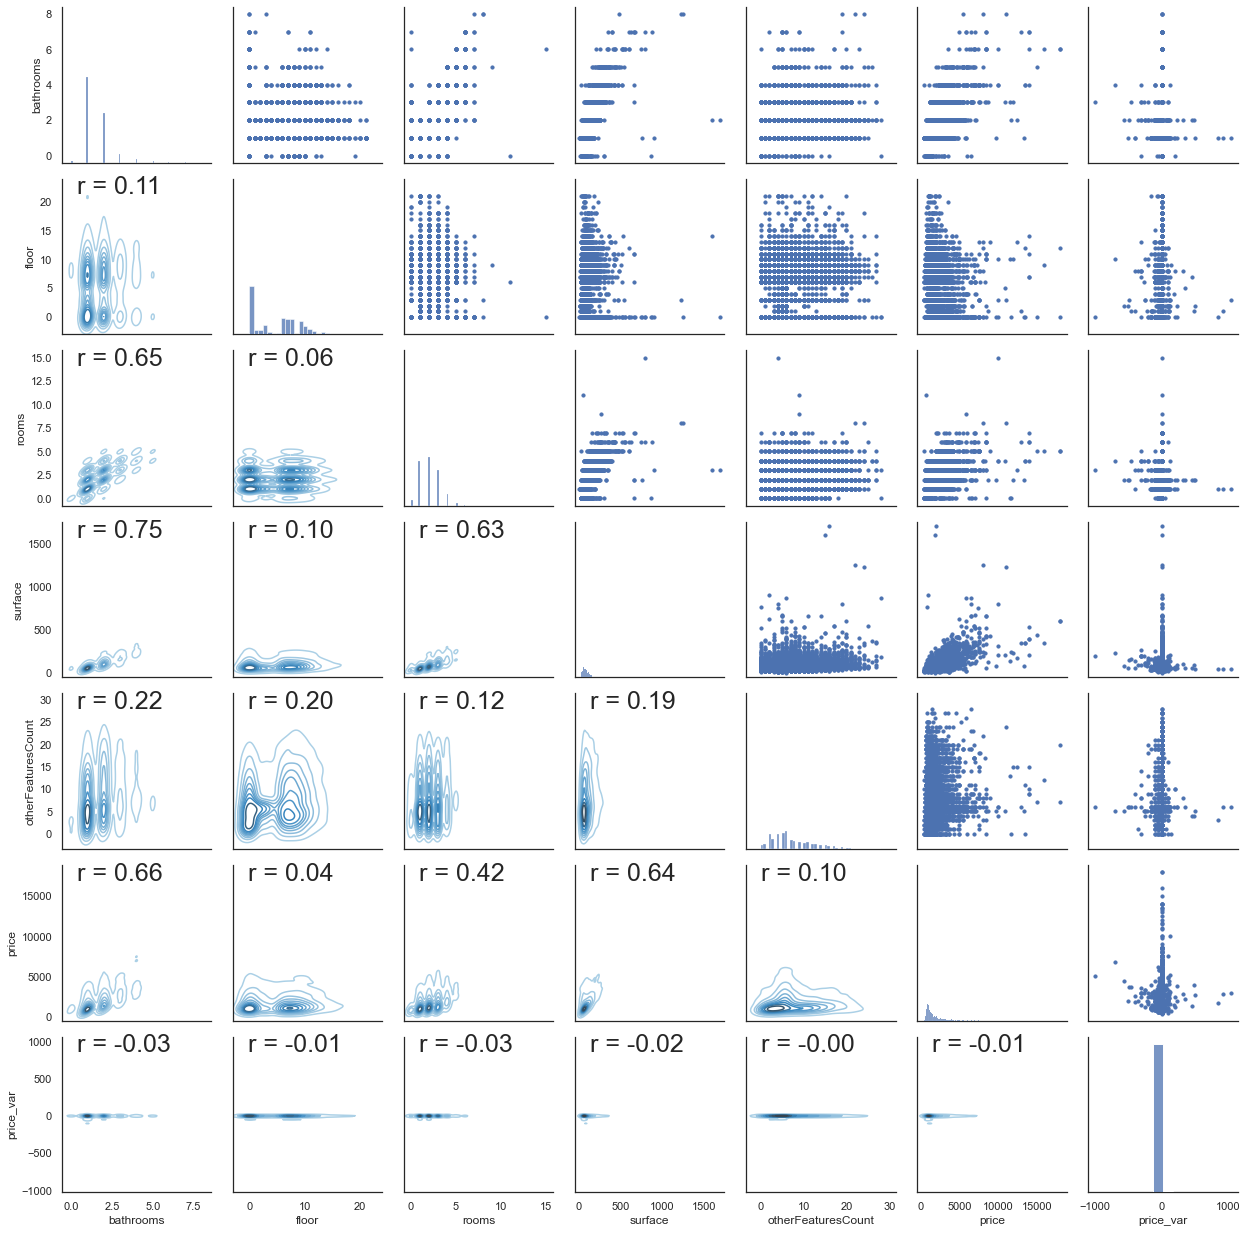

In [38]:
from scipy import stats

to_pairGrid = alquiler[['bathrooms', 'floor', 'rooms', 
                       'surface', 'otherFeaturesCount', 'price', 'price_var']]


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes,
                fontsize=25)


g = sns.PairGrid(to_pairGrid, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

En este gráfico podemos en la diagonal la representación del histograma de la correspondiente variable, en la zona inferior la función de densidad (con el coeficiente de correlación de Pearson), y en la zona superior el diagrama de dispersión. De esta información podemos concluir que:
* El número de baños tiene una correlación más fuerte con el precio que el número de habitaciones
* También existe una fuerte correlación entre la superficie y el precio
* La planta no determina el precio del alquiler, como tampoco lo hace la cantidad de características adicionales de la vivienda.

Vemos que existen combinaciones de valores en torno a las habitaciones y los baños que nos dan a entender que la sustitución de valores nulos por valores 0 pudo no se correctas para estas variables, probablemente sea mejor determinar el valor que sustituye al nulo de forma similar a como se hizo con el precio y la superficies, es decir, utilizando `KNNImptuer`

A continuación podemos ver las combinaciones de valores 0 en _bathroom_ o _room_. Algunos casos son especialmente llamativos como la combinación de 11 habitaciones y 0 baños.

In [39]:
x = alquiler.groupby(['rooms', 'bathrooms', 'buildingSubtype']).size().to_frame('count').reset_index()
x[((x.rooms==0) | (x.bathrooms==0))&(x['count']>0)]

,rooms,bathrooms,buildingSubtype,count
0,0,0,Apartment,3
3,0,0,Duplex,1
4,0,0,Flat,16
6,0,0,House_Chalet,1
7,0,0,Loft,3
10,0,0,Study,7
11,0,1,Apartment,3
12,0,1,Attic,7
14,0,1,Duplex,1
15,0,1,Flat,35


Por lo comentado se realizará una imputación de valores nulos en aquellos registros que tienen 0 en _bathroom_ o _room_ y, posteriormente, se aplicará la imputación utlizando KNN para sustituirlo por el valor más habitual entre sus 5 vecinos más cercanos.

In [40]:
alquiler[['bathrooms', 'rooms']] = alquiler[['bathrooms', 'rooms']].replace(0, np.nan)

sum(alquiler.bathrooms.isnull()), sum(alquiler.rooms.isnull())

(55, 265)

In [41]:
# Hacemos una copia del dataset y eliminamos variables que no nos interesan
cols_knn = [
    'zipCode', 'buildingSubtype', 'clientTypeId', 'bathrooms', 'balcony',
    'air_conditioner', 'heater', 'heating', 'swimming_pool', 'parking',
    'conservationState', 'floor', 'terrace', 'elevator', 'rooms', 'surface',
    'isHighlighted', 'isPackPremiumPriority', 'isNewConstruction',
    'isOpportunity', 'otherFeaturesCount', 'price']
knn_df = alquiler[cols_knn].copy()

# Convertimos las categóricas a su código numérico y eliminamos las datetime
for feat in knn_df.columns:
    if knn_df[feat].dtype == 'category':
        knn_df[feat] = knn_df[feat].cat.codes
    elif knn_df[feat].dtype == 'datetime64[ns]':
        knn_df.drop(feat, inplace=True, axis=1)

In [42]:
knn = KNNImputer(n_neighbors=5)
knn_df[knn_df.columns] = knn.fit_transform(knn_df)

In [43]:
alquiler['bathrooms'] = knn_df['bathrooms'].astype("int8")
alquiler['rooms'] = knn_df['rooms'].astype("int8")

Se revisa a ver si queda algún valor 0 o nulo en alguna de estas variables

In [44]:
sum(alquiler.bathrooms.isnull()), sum(alquiler.bathrooms == 0)

(0, 0)

In [45]:
sum(alquiler.rooms.isnull()), sum(alquiler.rooms == 0)

(0, 0)

Vamos a ver el resultado de realizar la sustitución de los valores no válidos mediante KNN en los gráficos de correlación que vimos antes del cambio

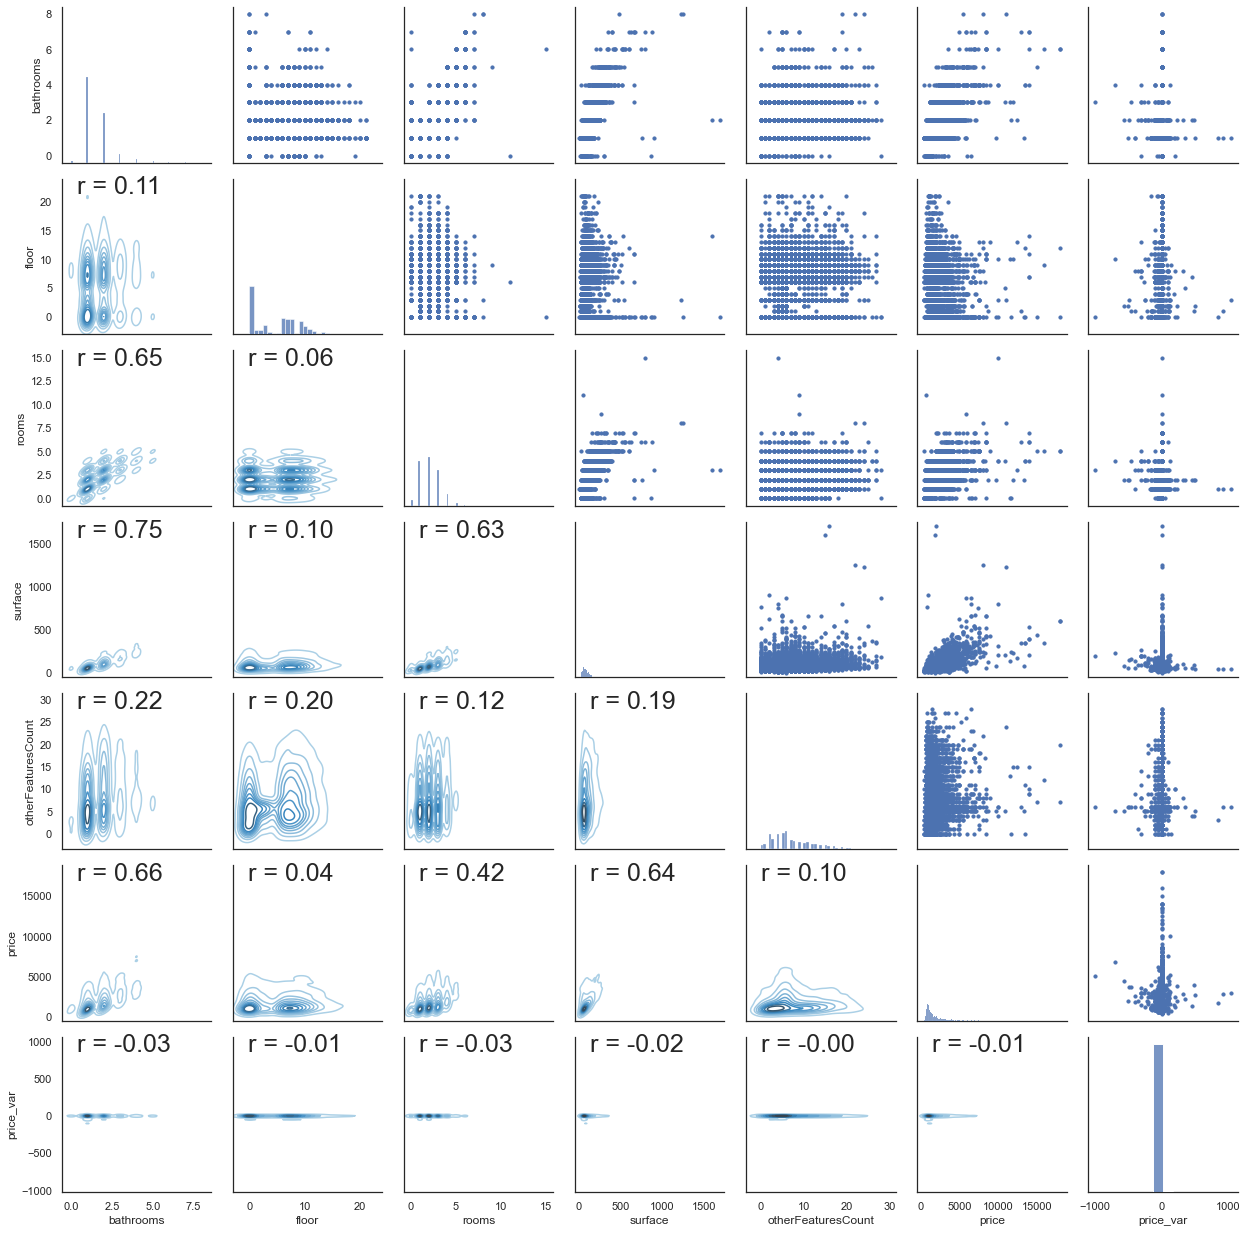

In [46]:
g = sns.PairGrid(to_pairGrid, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

## Conjunto final

### Añadir variables

Se añaden columnas de apoyo al cálculo de la variable target:
* publishedUntil : Esta columna tendrá la fecha de última publicación de un anuncio. Los que estuvieran vigentes en el momento en el que se ejecutó el último proceso (11 abril 2022 07 h.) se pondrán con valor nulo, el resto tendrán la fecha de último acceso.
* publishedDays : Esta columna tendrá el número de días que ha estado publicado el anuncio

Con estas dos columnas podremos calcular la variable target que vamos a utilizar y que va a indicar si el inmueble se alquila en más o menos de tres días.

In [47]:
# Cáculo del numero de días y la fecha hasta la que estuvo publicado
# un anuncio
alquiler['publishedUntil'] = alquiler.lastAccess.astype('datetime64[ns]')

# Las que tienen la fecha de último acceso correspondiente al último proceso
# se ponen a nulos, pues no se conoce cuando desaparece el anuncio.
alquiler.loc[(alquiler['lastAccess'] >= "2022-04-11"),'publishedUntil'] = pd.NaT

alquiler['publishedDays'] = alquiler.publishedUntil - alquiler.dateOriginal

# True si fue alquilado en 3 días o menos.
alquiler['target'] = alquiler['publishedDays'] <= pd.Timedelta(days=3)

# Eliminamos variables utilizadas para calcular target
alquiler.drop(['lastAccess', 'publishedUntil'], axis=1, inplace=True)

Con todo los procedimientos realizados anteriormente obtenemos el siguiente resultado:

In [48]:
alquiler.head()

,zipCode,buildingSubtype,clientTypeId,dateOriginal,bathrooms,balcony,air_conditioner,heater,heating,swimming_pool,...,isHighlighted,isPackPremiumPriority,isNewConstruction,isOpportunity,otherFeaturesCount,price,periodicityId,price_var,publishedDays,target
0,28023,GroundFloorWithGarden,Inmob.,2022-02-24,2,0,0,0,0,0,...,False,True,False,False,15,1325.0,Mensual,0,NaT,False
1,28023,Flat,Inmob.,2022-02-23,2,0,0,0,0,0,...,False,True,False,False,15,1120.0,Mensual,0,NaT,False
2,28052,GroundFloorWithGarden,Inmob.,2022-03-10,2,0,0,0,0,0,...,False,True,False,False,18,1095.0,Mensual,0,NaT,False
3,28050,Flat,Inmob.,2022-03-01,2,0,0,0,0,0,...,False,True,False,False,17,1045.0,Mensual,0,NaT,False
4,28001,Flat,Inmob.,2022-02-24,3,1,1,1,0,0,...,False,True,False,False,19,6550.0,Mensual,0,NaT,False


El cual guardamos en nuestra carpeta *data*:

In [49]:
alquiler.to_csv("../data/madrid-rent-prices_cleaned.csv")

Vamos a grabar también el fichero en formato parquet para aprovecharnos de que este formato guarda los datos con su formato, por lo que al leerlos no necesitamos inferir los tipos, se utilizaran los tipos tal cual están definidos en el DataFrame actual.

In [50]:
alquiler.to_parquet("../data/madrid-rent-prices_cleaned.parquet")

In [51]:
## En fichero aparte grabamos solo los mensajes que fueron dados de alta entre el 4 y el 8 de abril.
## Este rango de fechas asegura que todos los anuncios tuvieron el periodo suficiente para completar
## la variable target.
#
#  8 abril + 3 días = 11 abril. Si el inmueble se vendió en 3 días o menos el último día de proceso
#  el anuncio no debería estar activo.
#  Los anuncios que se dieron de alta el 9 de abril no pudieron completar el ciclo de 3 días activos
alquiler.loc[(dataset.dateOriginal>="2022-04-04") & (dataset.dateOriginal<="2022-04-08")]\
        .to_parquet("../data/madrid-rent-prices_4-8_cleaned.parquet")